## fun with [gaia-kepler.fun](http://gaia-kepler.fun)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import astropy.coordinates as coord

In [2]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1. #set the value globally

### Load up the Kepler crossmatch data and check it out:

In [3]:
kep_data = Table.read('../data/kepler_dr2_4arcsec.fits', format='fits')

In [4]:
kep_data.info

<Table masked=True length=241989>
          name           dtype         unit       n_bad
----------------------- ------- ----------------- -----
                angDist float64            arcsec     0
                  kepid   int64                       0
              source_id   int64                       0
                ra_gaia float64               deg     0
               ra_error float64      0.001 arcsec     0
               dec_gaia float64               deg     0
              dec_error float64      0.001 arcsec     0
               parallax float64      0.001 arcsec     0
         parallax_error float64      0.001 arcsec     0
                   pmra float64 0.001 arcsec / yr     0
             pmra_error float64 0.001 arcsec / yr     0
                  pmdec float64 0.001 arcsec / yr     0
            pmdec_error float64 0.001 arcsec / yr     0
       phot_g_mean_flux float64            ph / s     0
 phot_g_mean_flux_error float64            ph / s     0
        phot_g

Let's calculate a few helpful quantities like distance and absolute magnitude:

In [5]:
kep_data['dist'] = 1.e3/kep_data['parallax']
kep_data['dist'].unit = u.pc
kep_data['abs_gmag'] = kep_data['phot_g_mean_mag'] - \
                            5.*(np.log10(kep_data['dist']) - 1.)
kep_data['abs_gmag'].unit = u.mag

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Now let's plot a color-magnitude diagram! Notice that we make some cuts to ensure that the stars are bright (G <= 18) and parallax measurements are above 0.1 mas. This is to cut out some of the less well-measured targets.

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


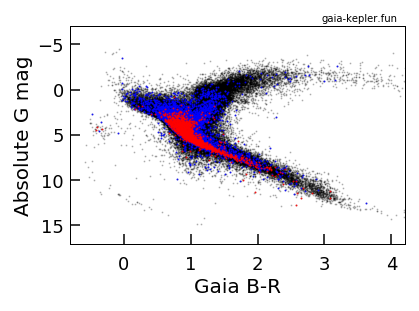

In [7]:
filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax'] > 0.1)
plt.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], alpha=0.2, color='k', s=1)
filter2 = (kep_data['planet?'] == 'cand') & filter
plt.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], alpha=0.7, s=1, color='b')
filter2 = (kep_data['planet?'] == 'conf') & filter
plt.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], alpha=0.7, s=1, color='r')
plt.xlabel('Gaia B-R', fontsize=20)
plt.ylabel('Absolute G mag', fontsize=20)
plt.ylim([17,-7])
plt.xlim([-0.8,4.2])
plt.text(0.75,1.02,'gaia-kepler.fun', transform=plt.gca().transAxes)
plt.savefig('../img/colormag_kepler.png')

(The above code makes candidate planet host stars blue and confirmed planet host stars red.)

### Now we'll do the same for K2!

In [8]:
k2_data = Table.read('../data/k2_dr2_4arcsec.fits', format='fits')

In [9]:
k2_data['dist'] = 1.e3/k2_data['parallax']
k2_data['dist'].unit = u.pc
k2_data['abs_gmag'] = k2_data['phot_g_mean_mag'] - \
                            5.*(np.log10(k2_data['dist']) - 1.)
k2_data['abs_gmag'].unit = u.mag

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


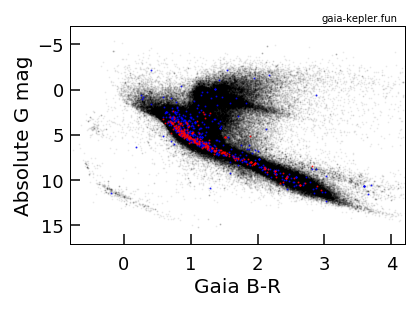

In [10]:
filter = (k2_data['phot_g_mean_mag'] <= 18.) & (k2_data['parallax'] > 0.1)
plt.scatter(k2_data['bp_rp'][filter], k2_data['abs_gmag'][filter], alpha=0.05, color='k', s=1)
filter2 = (k2_data['k2c_disp'] == 'CANDIDATE') & filter
plt.scatter(k2_data['bp_rp'][filter2], k2_data['abs_gmag'][filter2], alpha=0.7, s=1, color='b')
filter2 = (k2_data['k2c_disp'] == 'CONFIRMED') & filter
plt.scatter(k2_data['bp_rp'][filter2], k2_data['abs_gmag'][filter2], alpha=0.7, s=1, color='r')
plt.xlabel('Gaia B-R', fontsize=20)
plt.ylabel('Absolute G mag', fontsize=20)
plt.ylim([17,-7])
plt.xlim([-0.8,4.2])
plt.text(0.75,1.02,'gaia-kepler.fun', transform=plt.gca().transAxes)
plt.savefig('../img/colormag_k2.png')

### Fun with proper motions:

In [8]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import animation
from IPython.display import HTML
from astropy.time import Time

Filter out the poorly measured stars:

In [9]:
filter = (kep_data['phot_g_mean_mag'] >= 18.) & (kep_data['parallax'] > 0.01)
tab = kep_data[filter]

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [10]:
gaia_time = Time('2015-01-01')
tab['radial_velocity'][np.isnan(tab['radial_velocity'])] = 0.

(We have to zero out the non-measured RVs because otherwise astropy NaNs everything...)

Let's inflate the PMs, RVs, and parallaxes so they're visible:

In [11]:
amplitude = 1e5
tab['radial_velocity'] *= amplitude
tab['pmra'] *= amplitude
tab['pmdec'] *= amplitude
tab['parallax'] *= amplitude

Make SkyCoord objects with astropy. This will allow us to easily calculate the stars' positions at different dates (but it doesn't like dates like JD = 500000, which is why we had to artificially inflate the motions for what we'll do below).

In [12]:
scnow = SkyCoord(ra=tab['ra_gaia'], dec=tab['dec_gaia'], 
                 distance=(np.array(tab['parallax'])*u.mas).to(u.pc, u.parallax()),
                 radial_velocity=tab['radial_velocity'],
                 pm_ra_cosdec=tab['pmra']*np.cos(tab['dec_gaia'].to(u.rad)), 
                 pm_dec=tab['pmdec'], obstime=gaia_time
                )
mag = tab['phot_g_mean_mag']

Function that moves all stars forward or backward by "t" years and plots them:

In [28]:
def animfunc(t, xlim, ylim, ax):
    sclater = scnow.apply_space_motion(new_obstime=gaia_time + t * u.yr)
    
    ax.cla()
    ax.set_title('Kepler field, T={:,.0f} years'.format(t*amplitude), fontsize=18)
    s = ax.scatter(sclater.ra.deg, sclater.dec.deg, c=np.log10(sclater.distance.value), 
               **scatkwargs)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Right Ascension (degrees)', fontsize=16)
    ax.set_xlabel('Declination (degrees)', fontsize=16)
    ax.grid(alpha=.5)
    #cbar = fig.colorbar(s, ax=ax, ticks=[1,2,3,4,5])
    #cbar.ax.set_yticklabels(['10', '100', '1000', '10k', '100k'])  # vertically oriented colorbar
    #cbar.set_label('Distance (pc)', rotation=270)

matplotlib animation:

In [31]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot()

scatkwargs = dict(alpha=.7, s=3, cmap='viridis')

times = np.linspace(-5., 0., 51)
times = np.append(times, np.zeros(20))
times = np.append(times, np.linspace(0., 5., 51))

anim1 = animation.FuncAnimation(fig, animfunc, times,
                                fargs=([275,305], [33,55], ax), 
                                interval=50)

plt.close(fig)
#HTML(anim1.to_html5_video())

In [30]:
anim1.save('kepler_propermotions.gif', dpi=80, writer='imagemagick')